# Transfer learning (from ImageNet dataset) with MobileNetV2

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import random as python_random
from collections import defaultdict
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU, CategoricalAccuracy, IoU
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.metrics import Mean
from tensorflow.keras.metrics import Metric
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2DTranspose
from sklearn.utils import shuffle
from tensorflow.keras.utils import register_keras_serializable
import math

Loading images

In [2]:
RAW_IMAGES_DIR = '701_StillsRaw_full'
LABELED_IMAGES_DIR = 'LabeledApproved_full'

def load_images_from_directory(directory, convert_rgb=True):
    images = []
    filenames = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith('.png'):
            img = Image.open(os.path.join(directory, filename))
            if convert_rgb:
                img = img.convert('RGB')
            img = remove_iccp_profile(img)
            if img is not None:
                images.append(np.array(img))
                filenames.append(filename)
    return images, filenames

def remove_iccp_profile(image):
    if 'icc_profile' in image.info:
        del image.info['icc_profile']
    return image

raw_images, raw_filenames = load_images_from_directory(RAW_IMAGES_DIR)
labeled_images, labeled_filenames = load_images_from_directory(LABELED_IMAGES_DIR)

print(f"Loaded {len(raw_images)} raw images and {len(labeled_images)} labeled images")

Loaded 701 raw images and 701 labeled images


Shuffling images in order to break temporal correlation and resizing images from 720x940 to 224x224 pixels, using bicubic interpolation for raw images and nearest neighbour for labels.

Also, normalization of the images is applied.

In [3]:
raw_images, labeled_images = shuffle(raw_images, labeled_images, random_state=42)

def resize_images_bicubic(images, target_size=(224, 224)):
    resized_images = []
    for img in images:
        resized = cv2.resize(img, target_size, interpolation=cv2.INTER_CUBIC)
        resized_images.append(resized)
    return resized_images

def resize_labels_nearest(images, target_size=(224, 224)):
    resized_images = []
    for img in images:
        resized = cv2.resize(img, target_size, interpolation=cv2.INTER_NEAREST)
        resized_images.append(resized)
    return resized_images

images = resize_images_bicubic(raw_images)
labels = resize_labels_nearest(labeled_images)

images = [image / 255.0 for image in images]
images = np.array(images, dtype=np.float32)  

label_colors = {
    (64, 128, 64): 0,    # Animal
    (192, 0, 128): 1,    # Archway
    (0, 128, 192): 2,    # Bicyclist
    (0, 128, 64): 3,     # Bridge
    (128, 0, 0): 4,      # Building
    (64, 0, 128): 5,     # Car
    (64, 0, 192): 6,     # CartLuggagePram
    (192, 128, 128): 7,  # Child
    (192, 192, 128): 8,  # Column_Pole
    (64, 64, 128): 9,    # Fence
    (128, 0, 192): 10,   # LaneMkgsDriv
    (192, 0, 64): 11,    # LaneMkgsNonDriv
    (128, 128, 64): 12,  # Misc_Text
    (192, 0, 192): 13,   # MotorcycleScooter
    (128, 64, 64): 14,   # OtherMoving
    (64, 192, 128): 15,  # ParkingBlock
    (64, 64, 0): 16,     # Pedestrian
    (128, 64, 128): 17,  # Road
    (128, 128, 192): 18, # RoadShoulder
    (0, 0, 192): 19,     # Sidewalk
    (192, 128, 192): 20, # SignSymbol
    (128, 128, 128): 21, # Sky
    (64, 128, 192): 22,  # SUV_PickupTruck
    (0, 0, 64): 23,      # TrafficCone
    (0, 64, 64): 24,     # TrafficLight
    (192, 64, 128): 25,  # Train
    (128, 128, 0): 26,   # Tree
    (192, 128, 0): 27,   # Truck_Bus
    (64, 0, 64): 28,     # Tunnel
    (192, 192, 0): 29,   # VegetationMisc
    (0, 0, 0): 30,       # Void
    (64, 192, 0): 31     # Wall
}

num_classes = 32

def rgb_to_index(mask):
    label_map = np.zeros((mask.shape[0], mask.shape[1]), dtype=int)
    for rgb, index in label_colors.items():
        matches = np.all(mask == np.array(rgb), axis=-1)
        label_map[matches] = index
    return label_map

encoded_labels = []

for label in labels:
    class_indices = rgb_to_index(label)
    encoded_labels.append(class_indices)

labels = encoded_labels

Splitting into train and validation set (test set definition will be used afterwards).

In [4]:
x_train = np.array(images[0:400])
y_train = np.array(labels[0:400])

x_val = np.array(images[401:551])
y_val = np.array(labels[401:551])

#x_test = np.array(images[552:701])
#y_test = np.array(labels[552:701])

Same data augmentation as for the model from scratch

In [5]:
class CustomAugmentation:
    def __init__(self, prob=0.3, brightness_range=(-0.4, 0.4), contrast_range=(0.0, 2.0), saturation_range=(0.5, 2.0), max_noise=0.2, scale_range=(0.5, 1), rotation_range=(-20, 20)):
        self.scale_range = scale_range
        self.rotation_range = rotation_range
        self.max_noise = max_noise
        self.prob = prob
        self.brightness_range=brightness_range
        self.contrast_range=contrast_range
        self.saturation_range=saturation_range

    def random_flip(self, image, mask):
        flip = tf.random.uniform([]) < self.prob
        image = tf.cond(flip, lambda: tf.image.flip_left_right(image), lambda: image)
        mask = tf.cond(flip, lambda: tf.image.flip_left_right(mask), lambda: mask)
        return image, mask

    def adjust_brightness(self, image):
        apply_augmentation = tf.random.uniform([]) < self.prob
        image = tf.cond(
            apply_augmentation,
            lambda: tf.image.adjust_brightness(image, tf.random.uniform([], self.brightness_range[0], self.brightness_range[1])),
            lambda: image
        )
        image = tf.clip_by_value(image, 0.0, 1.0)
        return image

    def adjust_contrast(self, image):
        apply_augmentation = tf.random.uniform([]) < self.prob
        image = tf.cond(
            apply_augmentation,
            lambda: tf.image.adjust_contrast(image, tf.random.uniform([], self.contrast_range[0], self.contrast_range[1])),
            lambda: image
        )
        image = tf.clip_by_value(image, 0.0, 1.0)
        return image

    def adjust_saturation(self, image):
        apply_augmentation = tf.random.uniform([]) < self.prob
        image = tf.cond(
            apply_augmentation,
            lambda: tf.image.adjust_saturation(image, tf.random.uniform([], self.saturation_range[0], self.saturation_range[1])),
            lambda: image
        )
        return image

    def add_gaussian_noise(self, image):
        apply_augmentation = tf.random.uniform([]) < self.prob
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=self.max_noise, dtype=tf.float32)
        noisy_image = tf.cond(
            apply_augmentation,
            lambda: tf.clip_by_value(image + noise, 0.0, 1.0),
            lambda: image
        )
        return noisy_image

    def random_crop_and_resize(self, image, mask):
        apply_augmentation = tf.random.uniform([]) < self.prob
        return tf.cond(
            apply_augmentation,
            lambda: self._random_crop_and_resize(image, mask),
            lambda: (image, mask)
        )
    def _random_crop_and_resize(self, image, mask):
        # Generating a random scale factor
        scale_factor = tf.random.uniform([], self.scale_range[0], self.scale_range[1], dtype=tf.float32)
        height = tf.shape(image)[0]
        width = tf.shape(image)[1]

        # Calculating the size of the crop
        crop_height = tf.cast(tf.cast(height, tf.float32) * scale_factor, tf.int32)
        crop_width = tf.cast(tf.cast(width, tf.float32) * scale_factor, tf.int32)

        # Randomly selecting the top-left corner for cropping
        offset_height = tf.random.uniform([], 0, height - crop_height + 1, dtype=tf.int32)
        offset_width = tf.random.uniform([], 0, width - crop_width + 1, dtype=tf.int32)

        # Cropping the image and mask
        cropped_image = tf.image.crop_to_bounding_box(image, offset_height, offset_width, crop_height, crop_width)
        cropped_mask = tf.image.crop_to_bounding_box(mask, offset_height, offset_width, crop_height, crop_width)

        # Resizing the cropped image and mask back to the original dimensions
        resized_image = tf.image.resize(cropped_image, [height, width], method=tf.image.ResizeMethod.BICUBIC)
        resized_mask = tf.image.resize(cropped_mask, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        # Clipping pixel values to the valid range [0, 1]
        resized_image = tf.clip_by_value(resized_image, 0.0, 1.0)

        return resized_image, resized_mask

    def rotate_and_zoom(self, image, mask):
        apply_augmentation = tf.random.uniform([]) < self.prob
        return tf.cond(
            apply_augmentation,
            lambda: self._rotate_and_zoom(image, mask),
            lambda: (image, mask)
        )
    def _rotate_and_zoom(self, image, mask):
        # Selecting a random angle within the given range
        angle = tf.random.uniform([], self.rotation_range[0], self.rotation_range[1])
        radians = angle * math.pi / 180.0

        # Fixing image dimensions (only one needed since the images are of squared shape)
        size = tf.shape(image)[0]
        float_size = tf.cast(size, tf.float32)

        # Calculating the new size in a way the rotated image circumscribes the straight one
        new_dim = float_size * tf.abs(tf.cos(radians)) + float_size * tf.abs(tf.sin(radians))

        # Calculating the zoom factor
        zoom_factor = new_dim / float_size

        # Calculating the new dimensions after zoom
        zoomed_size = tf.cast(float_size * zoom_factor, tf.int32)

        # Resizing the image and mask
        zoomed_image = tf.image.resize(image, [zoomed_size, zoomed_size], method=tf.image.ResizeMethod.BICUBIC)
        zoomed_mask = tf.image.resize(mask, [zoomed_size, zoomed_size], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

        def get_rotation_matrix(angle, image_size):
            image_size=tf.cast(image_size, tf.float32)
            cos_theta = tf.cos(angle)
            sin_theta = tf.sin(angle)
            offset = (image_size - 1) / 2.0
            return tf.convert_to_tensor([
                [cos_theta, -sin_theta, offset - cos_theta * offset + sin_theta * offset],
                [sin_theta, cos_theta, offset - sin_theta * offset - cos_theta * offset],
                [0, 0, 1]
            ])

        # Applying the rotation transformation
        rotation_matrix = get_rotation_matrix(radians, zoomed_size)
        flat_rot_matrix = tf.reshape(rotation_matrix, [-1])[:8]

        rotated_image = tf.raw_ops.ImageProjectiveTransformV2(
            images=tf.expand_dims(zoomed_image, 0),
            transforms=[flat_rot_matrix],
            output_shape=[zoomed_size, zoomed_size],
            interpolation='BILINEAR'
        )
        rotated_mask = tf.raw_ops.ImageProjectiveTransformV2(
            images=tf.expand_dims(zoomed_mask, 0),
            transforms=[flat_rot_matrix],
            output_shape=[zoomed_size, zoomed_size],
            interpolation='NEAREST'
        )

        # Squeezing the extra dimension added by ImageProjectiveTransformV2
        rotated_image = tf.squeeze(rotated_image)
        rotated_mask = tf.squeeze(rotated_mask)

        # Calculating the offset for cropping
        offset = (zoomed_size - size) // 2

        # Cropping the image and mask to original dimensions
        cropped_image = tf.image.crop_to_bounding_box(rotated_image, offset, offset, size, size)
        cropped_mask = tf.image.crop_to_bounding_box(rotated_mask, offset, offset, size, size)

        cropped_image=tf.clip_by_value(cropped_image, 0.0, 1.0)

        return cropped_image, cropped_mask


    def __call__(self, image, mask):
        #image, mask = self.random_flip(image, mask)
        #image = self.adjust_brightness(image)
        #image = self.adjust_contrast(image)
        #image = self.adjust_saturation(image)
        image = self.add_gaussian_noise(image)
        image, mask = self.random_crop_and_resize(image, mask)
        image, mask = self.rotate_and_zoom(image, mask)
        return image, mask

Ensuring the label is of integer type and one-hot encoding it.
Note that one-hot encoding is needed, in particular, to allow an easier definition of the evaluation metrics.

In [6]:
def preprocess_and_encode(image, mask, num_classes):

    mask = tf.cast(mask, tf.int32)
    mask = tf.one_hot(mask, num_classes)

    return image, mask

Creating training and validation datasets.

In [9]:
def create_train_dataset(X, y, batch_size, buffer_size, num_classes):
    augmentor = CustomAugmentation()

    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = (
        dataset
        .map(lambda x, y: preprocess_and_encode(x, y, num_classes), num_parallel_calls=tf.data.AUTOTUNE)
        .shuffle(buffer_size)
        .map(lambda x, y: augmentor(x, y), num_parallel_calls=tf.data.AUTOTUNE)  # Apply augmentation here
        .batch(batch_size)
        .repeat()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    return dataset

def create_val_dataset(X, y, batch_size, num_classes):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    dataset = (
        dataset
        .map(lambda x, y: preprocess_and_encode(x, y, num_classes), num_parallel_calls=tf.data.AUTOTUNE)
        .batch(batch_size)
        .repeat()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )
    return dataset

batch_size=16
buffer_size=400
train_dataset = create_train_dataset(x_train, y_train, batch_size=batch_size, buffer_size=buffer_size, num_classes=num_classes)
val_dataset = create_val_dataset(x_val, y_val, batch_size=batch_size, num_classes=num_classes)

Creating a color mapping in order to visualize and check augmentations are correctly applied.

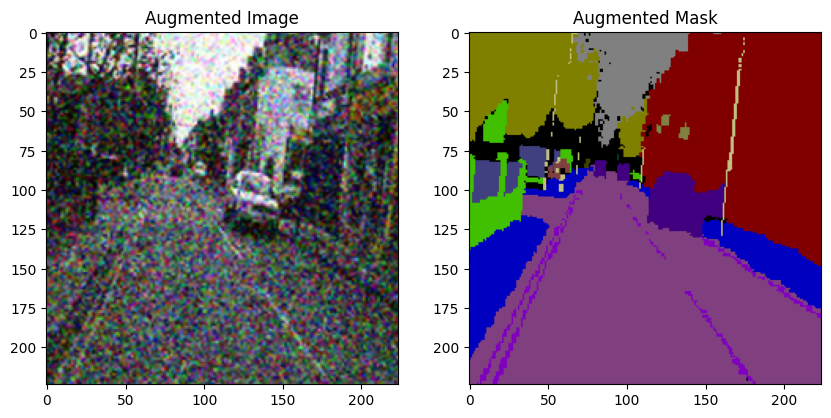

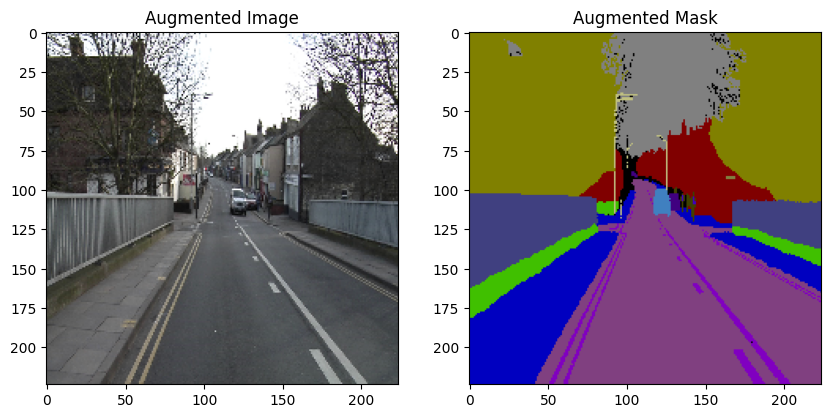

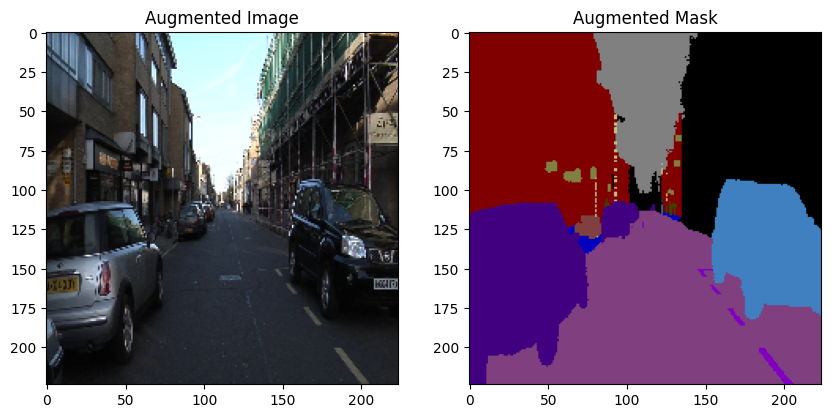

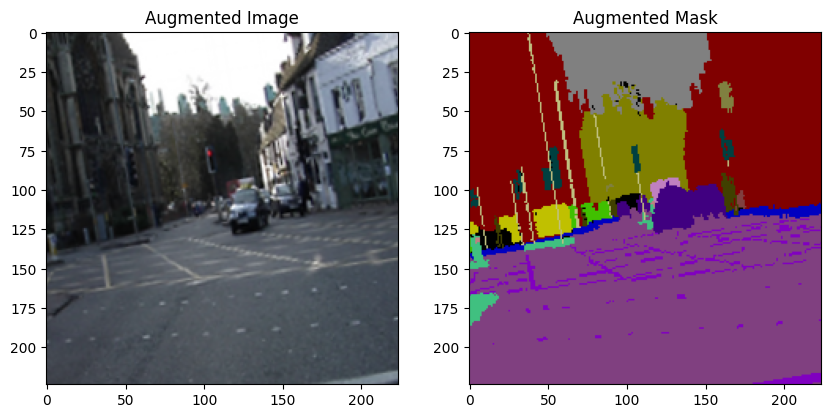

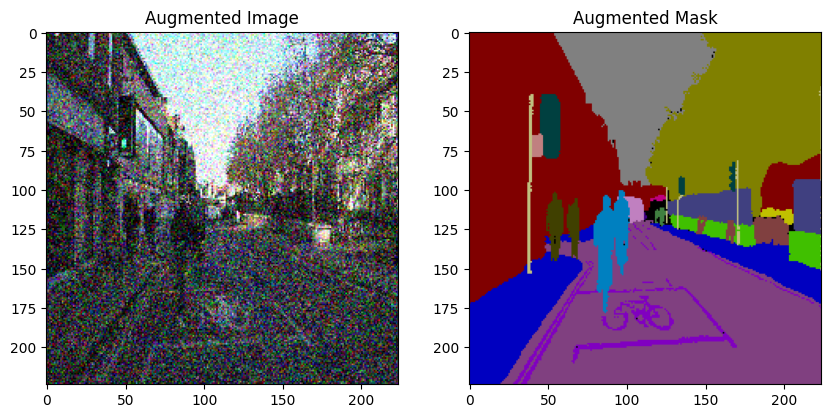

In [10]:
# Create a mapping from label index to RGB color
index_to_color = {v: k for k, v in label_colors.items()}

def map_colors(mask):
    mask = tf.argmax(mask, axis=-1)  # Get the class indices
    rgb_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for label, color in index_to_color.items():
        rgb_mask[mask == label] = color
    return rgb_mask

def visualize_augmentations(dataset, num_samples=5):
    for images, masks in dataset.take(num_samples):
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(images[0])
        axes[0].set_title("Augmented Image")
        # Visualize mask by mapping class indices to RGB colors
        colored_mask = map_colors(masks[0].numpy())
        axes[1].imshow(colored_mask)
        axes[1].set_title("Augmented Mask")
        plt.show()

visualize_augmentations(train_dataset)

### Model definition

This model leverages MobileNetV2 (trained on imagenet dataset) in the encoding path for efficient and effective feature extraction.

In [11]:
def create_model(input_shape, num_classes):
    base_model = MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet')

    for layer in base_model.layers:
        layer.trainable = False

    layer_dict = dict([(layer.name, layer) for layer in base_model.layers])

    block_names = ['block_1_expand_relu', 'block_3_expand_relu', 'block_6_expand_relu', 'block_13_expand_relu', 'block_16_project']
    blocks = [layer_dict[name].output for name in block_names]

    x = blocks[-1]
    
    for i, block in enumerate(reversed(blocks[:-1])):
        x = Conv2DTranspose(256 // (2 ** i), (3, 3), strides=2, padding='same')(x)
        x = concatenate([x, block])

    x = Conv2DTranspose(num_classes, (3, 3), strides=2, padding='same', activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

model = create_model((224, 224, 3), 32)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

### Loss function

Defining a custom loss function which implements a mask in order to ignore the void class (corresponding to index=30) within the categorical cross-entropy.

In [12]:
@register_keras_serializable()
def custom_categorical_crossentropy(y_true, y_pred):
    void_class = 30

    mask = tf.cast(tf.not_equal(tf.argmax(y_true, axis=-1), void_class), tf.float32)
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    loss *= mask

    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

### Mean Per Class Accuracy Metric

The "Mean Per Class Accuracy" is implemented to handle the class imbalance in the dataset. It measures the accuracy for each class independently and averages these accuracies, making each class equally relevant (without penalizations for being rare). Also, it excludes the void class.

In [13]:
@register_keras_serializable()
class MeanPerClassAccuracy(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='mean_per_class_accuracy', **kwargs):
        super(MeanPerClassAccuracy, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.total = self.add_weight(name='total', initializer='zeros', shape=(num_classes,))
        self.count = self.add_weight(name='count', initializer='zeros', shape=(num_classes,))

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)

        y_pred = tf.argmax(y_pred, axis=-1)

        # Create a mask to ignore the void class
        void_class = 30
        mask = tf.cast(tf.not_equal(y_true, void_class), 'float32')
        matches = tf.cast(tf.equal(y_true, y_pred), 'float32') * mask

        if sample_weight is not None:
            matches *= sample_weight

        per_class_masks = tf.equal(tf.expand_dims(y_true, axis=-1), tf.range(self.num_classes, dtype=y_true.dtype))
        per_class_matches = tf.reduce_sum(tf.cast(per_class_masks, dtype=tf.float32) * tf.expand_dims(matches, axis=-1), axis=[0, 1, 2])
        per_class_counts = tf.reduce_sum(tf.cast(per_class_masks, dtype=tf.float32) * tf.expand_dims(mask, axis=-1), axis=[0, 1, 2])

        self.total.assign_add(per_class_matches)
        self.count.assign_add(per_class_counts)

    def result(self):
        per_class_accuracy = tf.divide(self.total, tf.where(tf.equal(self.count, 0), tf.ones_like(self.count), self.count))
        return tf.reduce_mean(per_class_accuracy)

    def reset_state(self):
        self.total.assign(tf.zeros_like(self.total))
        self.count.assign(tf.zeros_like(self.count))

### Mean IoU

The "Mean IoU" (Intersection over Union) metric, similarly to the mean per class accuracy accounts for the void class, considers the one-hot encoding and computes the average value of the IoU for every class.

Then, the metrics for the evaluation of the model are chosen:
* Overall accuracy
* Mean accuracy
* Mean IoU

Finally the models is compiled with the categorical crossentropy loss function and the ADAM optimizer.

In [14]:
@register_keras_serializable()
class OneHotMeanIoU(MeanIoU):
    def __init__(self, num_classes, name='mean_iou', **kwargs):
        super(OneHotMeanIoU, self).__init__(num_classes=num_classes, name=name, **kwargs)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)

        # Create a mask to ignore the void class
        void_class = 30
        mask = tf.cast(tf.not_equal(y_true, void_class), tf.float32)
        y_true = tf.where(mask == 1, y_true, tf.zeros_like(y_true))
        y_pred = tf.where(mask == 1, y_pred, tf.zeros_like(y_pred))

        super().update_state(y_true, y_pred, sample_weight)

metrics = [
    tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
    MeanPerClassAccuracy(num_classes=32),
    OneHotMeanIoU(num_classes=32, name='mean_iou')
]

model.compile(
    optimizer='adam',
    loss=custom_categorical_crossentropy,
    metrics=metrics
)

configuration of the callbacks and model fit

In [15]:
callbacks = [
    ModelCheckpoint('model_best.keras', save_best_only=True, monitor='val_loss', mode='min'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)#,
    #EarlyStopping(monitor='val_loss', patience=15, verbose=1)
]

history = model.fit(train_dataset, 
    epochs=100, 
    validation_data=val_dataset,
    callbacks=callbacks,
    steps_per_epoch=len(x_train) // batch_size,  
    validation_steps=len(x_val) // batch_size
)

Epoch 1/100
25/25 [==============================] - 28s 169ms/step - loss: 2.2390 - categorical_accuracy: 0.3552 - mean_per_class_accuracy: 0.0531 - mean_iou: 0.0619 - val_loss: 1.3028 - val_categorical_accuracy: 0.6310 - val_mean_per_class_accuracy: 0.1000 - val_mean_iou: 0.1144 - lr: 0.0010
Epoch 2/100
25/25 [==============================] - 3s 116ms/step - loss: 1.2778 - categorical_accuracy: 0.6130 - mean_per_class_accuracy: 0.1033 - mean_iou: 0.1204 - val_loss: 0.9474 - val_categorical_accuracy: 0.7011 - val_mean_per_class_accuracy: 0.1334 - val_mean_iou: 0.1420 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - 3s 118ms/step - loss: 1.0930 - categorical_accuracy: 0.6611 - mean_per_class_accuracy: 0.1198 - mean_iou: 0.1377 - val_loss: 0.8570 - val_categorical_accuracy: 0.7321 - val_mean_per_class_accuracy: 0.1402 - val_mean_iou: 0.1545 - lr: 0.0010
Epoch 4/100
25/25 [==============================] - 3s 116ms/step - loss: 0.9455 - categorical_accuracy: 0.7114 - me

### Visualization of the model performance

The model is evaluated on the validation set considering the overall accuracy, mean per class accuracy, mean IoU (and the loss function).

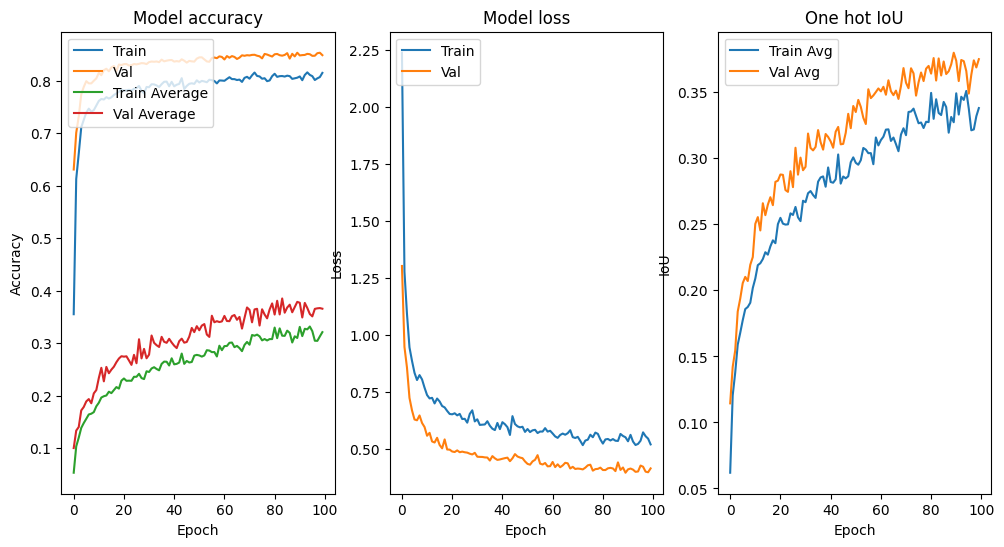

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.plot(history.history['mean_per_class_accuracy'])
plt.plot(history.history['val_mean_per_class_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val', 'Train Average', 'Val Average'], loc='upper left')

plt.subplot(1, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

plt.subplot(1, 3, 3)
plt.plot(history.history['mean_iou'])
plt.plot(history.history['val_mean_iou'])
plt.title('One hot IoU')
plt.ylabel('IoU')
plt.xlabel('Epoch')
plt.legend(['Train Avg', 'Val Avg'], loc='upper left')

plt.show()

In this plot, the relative frequency distribution of the ground truth is compared to the one of the predictions of the model in order to see if the model can approximate it or not.

5/5 [==============================] - 4s 360ms/step


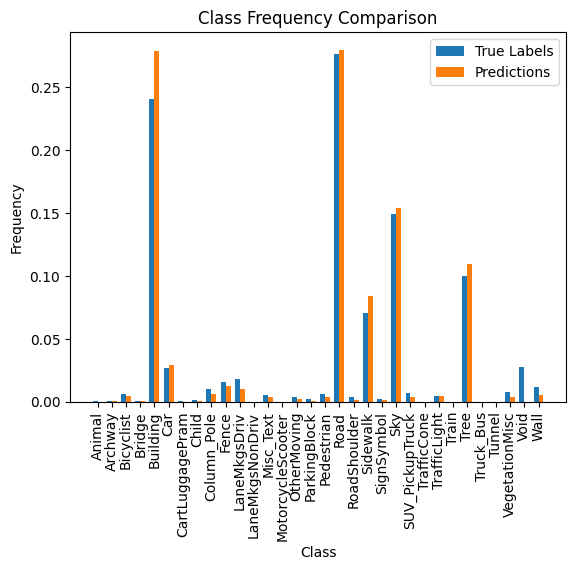

In [17]:
index_to_name = {
    0: 'Animal', 1: 'Archway', 2: 'Bicyclist', 3: 'Bridge', 4: 'Building',
    5: 'Car', 6: 'CartLuggagePram', 7: 'Child', 8: 'Column_Pole', 9: 'Fence',
    10: 'LaneMkgsDriv', 11: 'LaneMkgsNonDriv', 12: 'Misc_Text', 13: 'MotorcycleScooter',
    14: 'OtherMoving', 15: 'ParkingBlock', 16: 'Pedestrian', 17: 'Road',
    18: 'RoadShoulder', 19: 'Sidewalk', 20: 'SignSymbol', 21: 'Sky',
    22: 'SUV_PickupTruck', 23: 'TrafficCone', 24: 'TrafficLight', 25: 'Train',
    26: 'Tree', 27: 'Truck_Bus', 28: 'Tunnel', 29: 'VegetationMisc',
    30: 'Void', 31: 'Wall'
}

def calculate_class_frequencies(labels):
    class_sums = np.sum(np.eye(num_classes)[labels], axis=(0, 1, 2))
    total = np.sum(class_sums)
    relative_frequencies = class_sums / total if total > 0 else np.zeros_like(class_sums)
    return relative_frequencies

def calculate_prediction_frequencies(predictions):
    predictions_one_hot = np.eye(num_classes)[np.argmax(predictions, axis=-1)]
    pred_sums = np.sum(predictions_one_hot, axis=(0, 1, 2))
    total = np.sum(pred_sums)
    relative_frequencies = pred_sums / total
    return relative_frequencies

label_frequencies = calculate_class_frequencies(y_val)
predictions = model.predict(x_val)
prediction_frequencies = calculate_prediction_frequencies(predictions)

def plot_class_frequencies(label_freq, pred_freq):
    labels = range(len(label_freq))
    label_names = [index_to_name[idx] for idx in labels]
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(labels, label_freq, width, label='True Labels')
    rects2 = ax.bar([p + width for p in labels], pred_freq, width, label='Predictions')

    ax.set_xlabel('Class')
    ax.set_ylabel('Frequency')
    ax.set_title('Class Frequency Comparison')
    ax.set_xticks([p + width / 2 for p in labels])
    ax.set_xticklabels(label_names, rotation=90)
    ax.legend()
    plt.show()

plot_class_frequencies(label_frequencies, prediction_frequencies)

In the following code cell some random images are shown together with their labels and their predictions to observe the inference of the model.

1/1 [==============================] - 0s 16ms/step


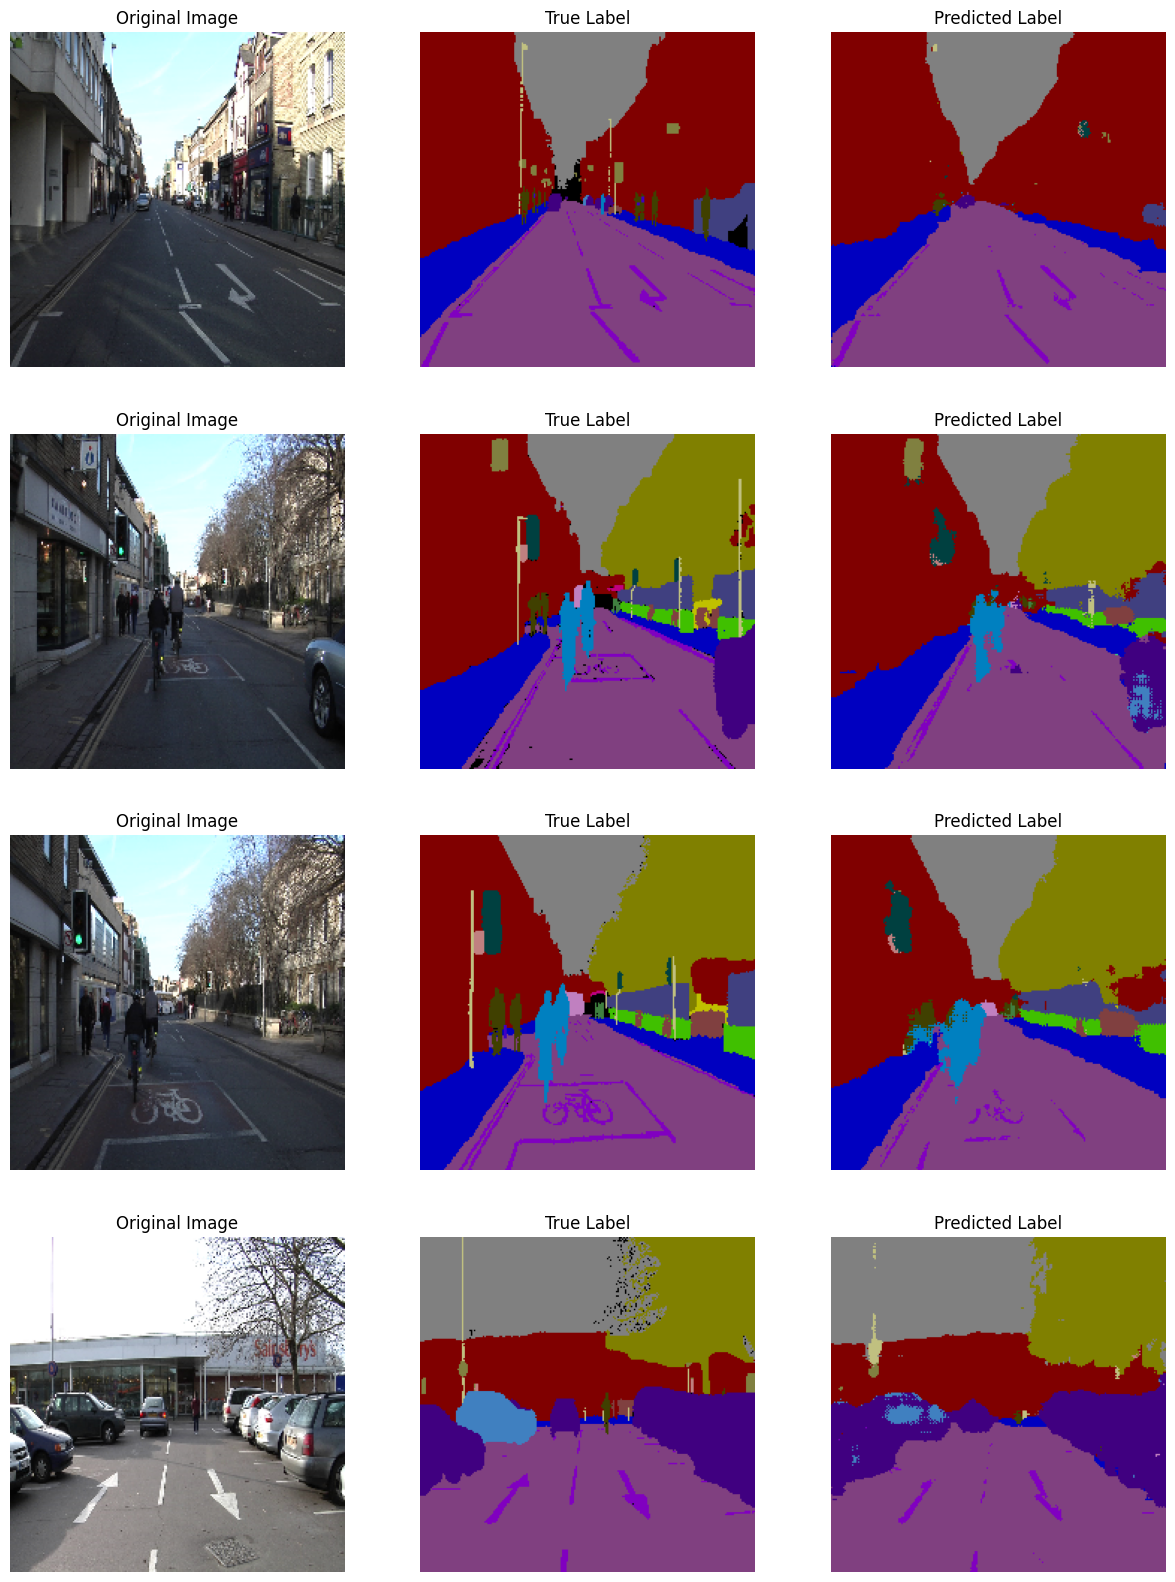

In [18]:
index_to_color = {v: k for k, v in label_colors.items()}

def map_colors(mask):
    """Map class indices to RGB colors."""
    rgb_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for label, color in index_to_color.items():
        rgb_mask[mask == label] = color
    return rgb_mask

def decode_predictions(preds, index_to_rgb):
    """Decode predictions from class indices to RGB colors."""
    output = np.zeros((preds.shape[0], preds.shape[1], 3), dtype=np.uint8)
    for cls in np.unique(preds):
        if cls in index_to_rgb:
            output[preds == cls] = index_to_rgb[cls]
        else:
            output[preds == cls] = [255, 255, 255]
            print(f"Warning: Class index {cls} not found in index_to_rgb dictionary. Assigning white color.")
    return output

num_images = 4
random_indices = np.random.choice(len(images), num_images, replace=False)

fig, axs = plt.subplots(num_images, 3, figsize=(15, 5 * num_images))
for i, idx in enumerate(random_indices):
    img = images[idx]
    true_label = labels[idx]
    true_label_rgb = map_colors(true_label)

    pred = model.predict(np.expand_dims(img, axis=0))
    pred_label = decode_predictions(np.argmax(pred[0], axis=-1), index_to_color)

    axs[i, 0].imshow(img)
    axs[i, 0].set_title('Original Image')
    axs[i, 0].axis('off')

    axs[i, 1].imshow(true_label_rgb)
    axs[i, 1].set_title('True Label')
    axs[i, 1].axis('off')

    axs[i, 2].imshow(pred_label)
    axs[i, 2].set_title('Predicted Label')
    axs[i, 2].axis('off')

plt.show()

To save the model:

In [19]:
model.save('MOBILENETV2'+ '.keras')